# Deepdive-llama3-from-scratch

<center>
    <img src="images/logo.png" width="600px"/>
</center>

This project is an enhanced version based on [naklecha/llama3-from-scratch](https://github.com/naklecha/llama3-from-scratch). It has been comprehensively improved and optimized on the basis of the original project, aiming to help everyone more easily understand and master the implementation principle and the detailed reasoning process of the Llama3 model. Thanks to the contributions of the original author :)
<br><br>
<span style="font-size: 1.2em; font-weight: bold;">
The following are the core improvements of this project:
</span>


1. **Structural Optimization**  
   The presentation sequence of the content has been rearranged, and the directory structure has been adjusted to make the learning process clearer and more reasonable, facilitating everyone to understand the code step by step.
   
2. **Code Annotations**  
   A large number of detailed code annotations have been added to teach you how to understand the function of each piece of code. Even beginners can get started easily.
   
3. **Dimension Tracking**  
   The changes in the matrix dimensions in each step of the calculation are fully annotated, making it easier for you to understand the entire process.
   
4. **Principle Explanation**  
   Abundant principle - related explanations and a large number of detailed derivations have been added. It not only tells you "what to do" but also deeply explains "why to do it", helping you fundamentally master the design concept of the model.
   
5. **KV-Cache Insights**  
   An additional derivation chapter on KV-Cache has been added, covering detailed core concepts, principle derivations, and the application process in the attention mechanism, allowing you to understand every detail and philosophy of KV-Cache from its roots. 
   
6. **Bilingual Documents**  
   Code files in both Chinese and English are provided. The native Chinese translation avoids the problem of inaccurate expressions caused by machine translation.
<br><br>   

<span style="font-size: 1.5em; font-weight: bold;">
Now, let's start the formal learning process!
</span>
<br><br>

In this file, I implemented Llama3 from scratch, one tensor and matrix multiplication at a time.
<br>
Also, I'm going to load tensors directly from the model file that meta provided for Llama3 (Meta-Llama-3-8B), you need to download the weights before running this file. Here is the offical link to download the weights: https://llama.meta.com/llama-downloads/
<br>
Note: This project uses the original model files, that is, the models in the "original" folder of the downloaded model files.
<br><br>

<span style="font-size: 1.5em; font-weight: bold;">
    Please Note! There is a small mistake in the figure:<br>
    <span style="font-size: 0.9em; font-weight: normal;">
        In each Transformer block, the input of the second "add" operation should be the output of the feed-forward layer and the output of the first "add" operation, instead of the result after normalization.
        <br>
        If we consider multi-head self-attention and feed-forward as the same type of operations (both for feature transformation), then the forms and processes of the two "normalization - feature transformation - residual connection (add)" are exactly the same.
    </span>
</span>

<div>
    <img src="images/archi.png"/>
</div>

# Loading the model
## Loading the tokenizer

The tokenizer is used to split the input text string into a sequence of sub-words, making it easier to input to the model.
<br>
I'm not going to implement a bpe tokenizer (but andrej karpathy has a really clean implementation), 
link to his implementation: https://github.com/karpathy/minbpe

<div>
    <img src="images/karpathyminbpe.png" width="600"/>
</div>
<br><br>

<span style="font-size: 1.2em; font-weight: bold;">Summary of the steps to load the BPE-based tokenizer:</span>

1. Loading regular words: Load the local tokenizer model dictionary (which only contains regular subwords and no special tokens).
2. Definition of the special words: Manually define special tokens (using ready-made ones or modifying based on the ready-made ones).
3. Definition of the text rough-splitting rule: Define the regular expression for text rough-splitting (just using a ready-made one). The input will go through two steps of rough-splitting (based on the regular expression) and fine-splitting (based on BPE) to obtain the final tokenization result.
4. Create tokenizer: Create a text encoder-decoder object based on the open-sourced tiktoken library by OpenAI (which can further split the rough-splitting result based on the BPE algorithm).

In [1]:
# Loading the BPE-based Tokenizer

# Import related libraries
from pathlib import Path  # Used to obtain the file name/model name from the file path
import tiktoken  # An open-source library developed by OpenAI for text encoding and decoding (mutual conversion between text and token IDs)
from tiktoken.load import load_tiktoken_bpe  # Load the BPE model
import torch  # Used for building models and matrix calculations
import json  # Used for loading configuration files
import matplotlib.pyplot as plt  # Used for plotting graphs


tokenizer_path = "Meta-Llama-3-8B/original/tokenizer.model"  # Path to the tokenizer model

# Special tokens outside the regular dictionary.
# These special tokens are present in the 'added_tokens' field of both 'tokenizer.json' and 'tokenizer_config.json' in the "Meta-Llama-3-8B/" path
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",  # Reserved special tokens from 0 to 250
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",  # Start of header information, used to mark the header information that wraps structured data, such as metadata
            "<|end_header_id|>",  # End of header information
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn, used to mark the end of the current turn in multi-turn conversations
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]


# Load the BPE model (actually a dictionary)
# A dictionary of subword(bytes type, decoded with utf-8)-rank(id) pairs, with 128000 words, not including the 256 special tokens above,
# so the total size of the model's dictionary will be 128256 in after operation (but not here)
# The rank values are an increasing sequence starting from 0, used to determine the priority order of subword unit merging,
# the higher the priority, the earlier the merging. Therefore, the variable name here is "mergeable_ranks" instead of something like BPE or word dictionary
# The special tokens are not added to the dictionary probably for flexibility,
# making it easy to add specific tokens when facing different model architectures or tasks with different special tokens, and keeping the dictionary size unchanged
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)


# Create a text encoder-decoder object
# The pat_str is roughly divided into three types: words with abbreviations & words, Chinese segments, 1-3-digit numbers & other special characters
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,  # Name of the encoder, which is convenient when debugging and logging to use different encoders
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",  # Regular expression for initially roughly splitting the text into a token sequence
    mergeable_ranks=mergeable_ranks,  # Pass in the loaded BPE model
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},  # Dictionary for adding special token-id pairs
)


# Test whether the creation is successful, that is, whether the encoder-decoder can run correctly
print(tokenizer.decode(tokenizer.encode("create tokenizer successed!")))


# The following is a case test to test the effects and differences between the rough splitting of pat_str and the fine splitting of the tokenizer
# The regular expression of pat_str only provides a preliminary splitting,
# some long sentences or Chinese text will not be split and will be further refined based on the BPE algorithm in the tokenizer
import regex  # Since some Unicode syntax such as \p{L} is used in pat_str, the re library cannot be used

## Create a regular expression
pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+"
pattern = regex.compile(pat_str)

## Text segmentation
text = "Hello world! It's a test. 这是一个测试. alongwords. a long words. 123 456 789."  # testing string
re_tokens = pattern.findall(text)  # Split the string using the regular expression
merge_tokens_id = tokenizer.encode(text)  # Split the string using the tokenizer
merge_tokens = [tokenizer.decode([i]) for i in merge_tokens_id]  # Convert the id sequence of the tokenizer's splitting result into an actual subword sequence

## Output result
print("Original string: ", text)
print("Regular expression splitting result: ", re_tokens)
print("Tokenizer splitting result: ", merge_tokens)
print("Tokenizer splitting result ids: ", list(zip(merge_tokens, merge_tokens_id)))

## From the results, it can be seen that the leading spaces of all words are retained, rather than being a single space token or being deleted.
## This is beneficial for the model to correctly understand the boundary information between words, such as 'alongwords' in the example.


_="""
Output result:

create tokenizer successed!
Original string: Hello world! It's a test. 这是一个测试. alongwords. a long words. 123 456 789.
Regular expression splitting result: ['Hello', ' world', '!', ' It', "'s", ' a', ' test', '.', ' 这是一个测试', '.', ' alongwords', '.',
               ' a', ' long', ' words', '.', ' ', '123', ' ', '456', ' ', '789', '.']
Tokenizer splitting result: ['Hello', ' world', '!', ' It', "'s", ' a', ' test', '.', ' 这', '是一个', '测试', '.',
                    ' along', 'words', '.', ' a', ' long', ' words', '.', ' ', '123', ' ', '456', ' ', '789', '.']
Tokenizer splitting result ids: [('Hello', 9906), (' world', 1917), ('!', 0), (' It', 1102), ("'s", 596), (' a', 264),
                      (' test', 1296), ('.', 13), (' 这', 122255), ('是一个', 122503), ('测试', 82805), ('.', 13),
                      (' along', 3235), ('words', 5880), ('.', 13), (' a', 264), (' long', 1317), (' words', 4339),
                      ('.', 13), (' ', 220), ('123', 4513), (' ', 220), ('456', 10961), (' ', 220), ('789', 16474), ('.', 13)]

"""

create tokenizer successed!
Original string:  Hello world! It's a test. 这是一个测试. alongwords. a long words. 123 456 789.
Regular expression splitting result:  ['Hello', ' world', '!', ' It', "'s", ' a', ' test', '.', ' 这是一个测试', '.', ' alongwords', '.', ' a', ' long', ' words', '.', ' ', '123', ' ', '456', ' ', '789', '.']
Tokenizer splitting result:  ['Hello', ' world', '!', ' It', "'s", ' a', ' test', '.', ' 这', '是一个', '测试', '.', ' along', 'words', '.', ' a', ' long', ' words', '.', ' ', '123', ' ', '456', ' ', '789', '.']
Tokenizer splitting result ids:  [('Hello', 9906), (' world', 1917), ('!', 0), (' It', 1102), ("'s", 596), (' a', 264), (' test', 1296), ('.', 13), (' 这', 122255), ('是一个', 122503), ('测试', 82805), ('.', 13), (' along', 3235), ('words', 5880), ('.', 13), (' a', 264), (' long', 1317), (' words', 4339), ('.', 13), (' ', 220), ('123', 4513), (' ', 220), ('456', 10961), (' ', 220), ('789', 16474), ('.', 13)]


## Reading model files and configuration files

Generally, reading a model file depends on how its model class is written and the variable names within it.
<br>
However, since we are implementing Llama3 from scratch, we will read one tensor file at a time.
<div>
    <img src="images/model.png" width="600"/>
</div>

In [2]:
# Load the model, a dictionary such as {"network-layer-name": tensor-type parameters}
model = torch.load("Meta-Llama-3-8B/original/consolidated.00.pth")

# Print the names of the first 20 network layers to verify if the model is loaded correctly.
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [3]:
# Load the configuration file.
# The specific meaning of each configuration is described in the next section.
with open("Meta-Llama-3-8B/original/params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

### Inferring model details using the configuration file

| Configuration Item | Configuration Value | Meaning |
| ---- | ---- | ---- |
| dim | 4096 | Dimension of the hidden layer, i.e., the vector representation of each token has a dimension of 4096. |
| n_layers | 32 | Number of model layers, i.e., the model has 32 Transformer layers or say Transformer blocks. |
| n_heads | 32 | Number of heads in multi-head attention, i.e., each multi-head attention block has 32 heads. The so-called multi-head means that multiple independent attention mechanisms are used simultaneously to capture different features or information of the input data. |
| n_kv_heads | 8 | Number of heads in key-value attention, used for Grouped Query Attention (GQA). That is, the key-value attention has 8 heads, while the query has n_heads=32 heads. Every 4 query heads will share a set of key-value pairs. |
| vocab_size | 128256 | Size of the vocabulary, including 128000 ordinary tokens and 256 special tokens. |
| multiple_of | 1024 | Multiple constraint on the dimension of the hidden layer. That is, the dimension of the model's hidden layer should be a multiple of 1024 to optimize computational efficiency. |
| ffn_dim_multiplier | 1.3 | Multiplier for the hidden layer dimension of the feed-forward network layer, used to calculate the hidden layer dimension of the FFN. The calculation process can be seen in the corresponding section. |
| norm_eps | 1e-05 | Constant added to the denominator in layer normalization calculation to prevent division by zero and ensure numerical stability. |
| rope_theta | 500000.0 | Basic frequency scaling factor in Rotary Position Encoding (RoPE), which controls the periodicity and resolution of position encoding, thus affecting the model's ability to capture sequences of different lengths and positional relationships. |

<br>

<span style="font-size: 1.2em; font-weight: bold;">
Based on the configuration details, the internal calculation process of attention given an input can be inferred as follows:
</span>

<pre>
input(L, 4096) -> query_proj(L, 128, 32)
               -> key_proj(L, 128, 8)
               -> value_proj(L, 128, 8)
                                           -> group_query_attention(L, 128, 32)
                                           -> output_proj(L, 4096)
                                                                                   -> output(L, 4096)
</pre>

In [4]:
# Record these configurations, which will be gradually used later.
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

# Convert the input text into embeddings

Before inputting the text in string form to the network layer, it needs to be converted into vector form for mathematical calculations.
<br>
The required process is: use the tokenizer to split the input text into a subword sequence -> convert the subwords into vector representations.

## Convert the text into a sequence of token ids
Here, we use tiktoken (a library from OpenAI) as the tokenizer.
<div>
    <img src="images/tokens.png" width="600"/>
</div>

In [5]:
# Convert the input prompt into a sequence of token ids
prompt = "the answer to the ultimate question of life, the universe, and everything is "  # Input text
tokens = [128000] + tokenizer.encode(prompt)  # Perform subword segmentation and add a special token <|begin_of_text|> indicating the start of the text at the beginning of the text. Dimension: [17]
print(tokens)  # Check the segmentation result
tokens = torch.tensor(tokens)  # Convert to tensor type for subsequent matrix calculations. [17]

# Convert the token ids into a specific sequence of token subwords, which is only for display purposes and not actually needed
prompt_split_as_tokens = [tokenizer.decode([token]) for token in tokens]
print(prompt_split_as_tokens)

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


## Convert the sequence of token ids into embeddings

Sorry, this is the only part in this codebase where I use built-in neural network modules.
<br>
In short, our original [17x1] token sequence is now [17x4096], that is, 17 embeddings of length 4096 (one for each token).
<br><br>
Note: Pay attention to the change in the shape of this tensor, which will make it easier for you to understand the entire process (And i will annotate the shape changes in all steps).

<div>
    <img src="images/embeddings.png" width="600"/>
</div>

In [6]:
# Create an embedding network layer to map discrete token ids to a continuous vector space
embedding_layer = torch.nn.Embedding(vocab_size, dim)

# Update the parameters of the embedding network with the pre-trained parameter values in Llama3
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])

# Use the embedding network to convert the input sequence of token ids into vector representations
# The embedding network only looks up the corresponding vectors based on the ids in a dictionary and does not involve interactions between tokens.
# [17] -> [17x4096]
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)  # By default, it is in full-precision float32. Here, we change it to the half-precision format to reduce memory usage.

token_embeddings_unnormalized.shape

torch.Size([17, 4096])

# Build the first Transformer block

From the pre-trained parameters involved in the first Transformer block shown below, it includes:
1. Two normalizations (attention_norm and ffn_norm)
2. Implementation of the attention mechanism (4 attention.w)
3. Implementation of the feed-forward network layer (3 feed_forward.w)
4. (Of course, it also includes two residual connection operations that do not require pre-trained parameters)

In general, the operation process in a Transformer block is as follows:
<br>
Normalization -> Multi-head self-attention -> Residual connection -> Normalization -> Feed-forward neural network -> Residual connection

In [7]:
# Display all the weight parameters and their shapes of the first Transformer block
for k, v in model.items():
    if not k.startswith('layers'):
        continue
    if k.startswith('layers.1'):
        break
    print(k, v.shape)

layers.0.attention.wq.weight torch.Size([4096, 4096])
layers.0.attention.wk.weight torch.Size([1024, 4096])
layers.0.attention.wv.weight torch.Size([1024, 4096])
layers.0.attention.wo.weight torch.Size([4096, 4096])
layers.0.feed_forward.w1.weight torch.Size([14336, 4096])
layers.0.feed_forward.w3.weight torch.Size([14336, 4096])
layers.0.feed_forward.w2.weight torch.Size([4096, 14336])
layers.0.attention_norm.weight torch.Size([4096])
layers.0.ffn_norm.weight torch.Size([4096])


There are two points to note here:
1. The shape of the weight matrix of a neural network is (output dimension, input dimension). During the calculation, the parameter matrix W will be transposed to (input dimension, output dimension) and then multiplied by the input X, i.e., the output Y = XW.T. You will see this in the subsequent calculations.
2. Since Llama3 uses the grouped attention mechanism, every 4 query heads will share a set of kv vectors (for details, see the section on the details of the configuration file above). Therefore, the dimension of the weight matrix of kv is [1024, 4096], which is 1/4 of that of q ([4096, 4096]).

## Normalization

The normalization operation aims to constrain the scale differences in the data, avoiding issues such as unstable training process caused by excessive differences in vector values.
<br><br>
After normalization, the shape of the tensor remains [17x4096], the same as that of the embedding.
<div>
    <img src="images/norm.png" width="600"/>
</div>

### Using RMS normalization for embeddings

Llama3 uses the Root Mean Square (RMS) normalization method, and its calculation formula is shown in the figure below.
<br>
It should be noted that we need a norm_eps parameter (from the configurations) because we don't want to accidentally set the RMS to 0 and perform a division by zero.
<br>
The formula is as follows:
<div>
<img src="images/rms.png" width="600"/>
</div>
<br>

In addition, you may have noticed the gi parameter in the formula. This is a scaling factor learned during the model training process, used to scale the normalization result of each dimension again to enhance the model's expressive ability. Its dimension is the same as the feature dimension of the embedding, i.e., [4096].

In [8]:
# Define the calculation function for RMS normalization
# Each token will be normalized independently
# norm_weights is the pre-trained scaling factor (i.e., gi in the formula) to enhance the model's representational ability. It can be loaded from the model file and has 4096 dimensions
# torch.rsqrt used to calculates the reciprocal of the square root of a tensor, i.e., 1/RMS(a)
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

In [9]:
# Normalize the input
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])  # [17x4096] & [4096] -> [17x4096]
model["layers.0.attention_norm.weight"].shape, token_embeddings.shape

(torch.Size([4096]), torch.Size([17, 4096]))

## Implementing the single-head attention mechanism from scratch

In the calculation of multi-head attention on each layer, 32 heads are involved. However, the calculation processes of these heads are completely identical and independent. Therefore, in this section, we will first implement the single-head attention calculation process, and expand it to multi-head calculation in the next section.
<div>
    <img src="images/qkv.png" width="600"/>
</div>
<br><br>

<span style="font-size: 1.2em; font-weight: bold;">
The core calculation of the attention mechanism is the calculation formula shown in the following figure.
</span>

1. We need to obtain the query, key, and value vectors by performing a linear mapping on the input embeddings.
2. Subsequently, based on the QK vectors, we obtain the attention weights between tokens, that is, for each token, the scores of the importance or relevance of other tokens to it.
3. Finally, based on the attention weights, we weight the value vectors to obtain the attention results corresponding to each token.

<div>
    <img src="images/softmax.png" width="600px"/>
</div>

Back to the point. Let's first load the attention heads of the first-layer Transformer.
<br>
&gt; When we load the query, key, value, and output weight matrices from the model (the output weight is used for information fusion among multiple heads to generate the final attention output), we will notice that their shapes are: [4096x4096], [1024x4096], [1024x4096], [4096x4096].
<br>
&gt; At first glance, this seems strange because ideally, we would like the q, k, v of each head to be independent of each other (in which case their shapes would be: 32x[128x4096], 8x[128x4096], 8x[128x4096]).
<br>
&gt; The author of the code binds them together because this helps parallelize the multiplication calculation of the attention heads.
<br>
&gt; But we will unfold everything...

In [10]:
# Show the shapes of the attention weight matrices of the current q, k, v and o.
print(
    model["layers.0.attention.wq.weight"].shape,  # [4096x4096]
    model["layers.0.attention.wk.weight"].shape,  # [1024x4096]
    model["layers.0.attention.wv.weight"].shape,  # [1024x4096]
    model["layers.0.attention.wo.weight"].shape   # [4096x4096]
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


### Obtain the QKV vectors corresponding to the input tokens

In this section, we will convert the input token embeddings into query, key, and value vectors for the purpose of attention mechanism computation.

#### Obtain the query vector

##### Unfold the query weight matrix

We will first unfold the queries from multiple attention heads, and the final shape will be [32x128x4096].
<br>
Here, 32 is the number of attention heads in Llama3, 128 is the vector dimension of the query head, and 4096 is the dimension of the token embedding (the reason why the dimension of the embedding is in the last dimension is that when multiplying the input and the weight, it is usually = X*W.T, that is, multiplying by the transpose of the weight).

In [11]:
# Load and modify the shape of the query weight matrix of layers.0 to unfold it in the form of multiple heads
q_layer0 = model["layers.0.attention.wq.weight"]  # Default shape is [4096x4096]
head_dim = q_layer0.shape[0] // n_heads  # Dimension of the attention head, 4096/32 = 128
q_layer0 = q_layer0.view(n_heads, head_dim, dim)  # Unfolded dimension, [32x128x4096]
q_layer0.shape

torch.Size([32, 128, 4096])

##### Obtain the first head
Here, I access the first head of the query weight matrix in the first layer. The shape of this query weight matrix is [128x4096].

In [12]:
# Extract the weights of the first head
q_layer0_head0 = q_layer0[0]  # [32x128x4096] -> [128x4096]
q_layer0_head0.shape

torch.Size([128, 4096])

##### Multiply the token embeddings by the query weights to obtain the query vectors corresponding to the tokens

Here, you can see that the shape of the result is [17x128]. This is because we have 17 tokens, and for each token, there is a query vector of length 128.

<div>
    <img src="images/q_per_token.png" width="600"/>
</div>

In [13]:
# Calculate the query values of inputs on the first query head
# Q0_head0 = XW0_Q_head0.T
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)  # [17x4096] x [4096x128] = [17x128]
q_per_token.shape

torch.Size([17, 128])

#### Obtain the key vector (almost the same as the query vector)

<div>
    <img src="images/keys.png" width="600px"/>
</div>

I want to take a lazy, so I won't elaborate on the calculation process of the key vector again. Orz. The only thing you need to remember is:
<br>
&gt; The key also generates a 128-dimensional vector.
<br>
&gt; The number of parameters of the weight matrix of the key is only 1/4 of that of the query, because the weight of each key is shared by 4 heads simultaneously to reduce the required amount of calculation.

In [14]:
# Load and modify the shape of the key weight matrix of layers.0 to expand it in a multi-head form
# Different from the query weight matrix, the key has 8 attention heads, so the number of parameters is 1/4 of that of the query matrix
k_layer0 = model["layers.0.attention.wk.weight"]  # [1024x4096]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim) # [8x128x4096]
k_layer0.shape

torch.Size([8, 128, 4096])

In [15]:
# Extract the weights of the first head
k_layer0_head0 = k_layer0[0]  # [8x128x4096] -> [128x4096]
k_layer0_head0.shape

torch.Size([128, 4096])

In [16]:
# Calculate the key vectors corresponding to the inputs of the first head
# K0_head0 = XW0_K_head0.T
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)  # [17x4096] x [4096x128] = [17x128]
k_per_token.shape

torch.Size([17, 128])

#### Obtain the value vector (almost the same as the key vector)

<div>
    <img src="images/value.png" width="600px"/>
</div>

&gt; Similar to the key weights, the value weights are also shared by every 4 attention heads (to save computation).
<br>
&gt; Therefore, the shape of the value weight matrix is [8x128x4096].

In [17]:
# Load and modify the shape of the value weight matrix of layers.0 to expand it in a multi-head form
# Similar to the key weight matrix, the value also has 8 attention heads, so the number of parameters is also 1/4 of that of the query matrix
v_layer0 = model["layers.0.attention.wv.weight"]  # [1024x4096]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)  # [1024x4096] -> [8x128x4096]
v_layer0.shape

torch.Size([8, 128, 4096])

In [18]:
# Extract the weights of the first head
v_layer0_head0 = v_layer0[0]  # [8x128x4096] -> [128x4096]
v_layer0_head0.shape

torch.Size([128, 4096])

In [19]:
# Calculate the value vectors corresponding to the inputs of the first head
# V0_head0 = XW0_V_head0.T
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)  # [17x4096] x [4096x128] = [17x128]
v_per_token.shape

torch.Size([17, 128])

### Add positional information to the query and key vectors

- For natural language, the sequential relationship and relative positions between words are extremely important. For example, "The dog bites the man" and "The man bites the dog" have completely different semantic information. Moreover, our intuition also tells us that the correlation between relatively close words is usually greater than that between distant words.
- Therefore, we need to provide positional information between tokens during the attention calculation process, so that the model can better capture the dependencies in the sequence.
- Why add it to the query and key vectors? Because the query and key vectors are used to calculate the attention weights, i.e., the importance of each token to other tokens. This requires both of them to know the positions and relative positional relationships of any two tokens when calculating the similarity between them.
- Why not add it to the value vectors? Because the value vectors are only used for weighted summation. The positional information has already been considered in the interaction between the query and the key. Therefore, the value vectors only need to provide content information.

We will use RoPE (Rotary Position Encoding) to add positional information to these vectors.

#### Rotary Position Encoding (RoPE)

You can watch this video to understand its mathematical principles in detail (this is also the one I watched):
https://www.youtube.com/watch?v=o29P0Kpobz0&t=530s
<br><br>
The general idea of RoPE is to regard the vector as being in the complex space, and then generate specific rotation matrix based on positions. By multiplying the vector with the rotation matrix, rotation in the complex space can be achieved, thereby adding the relative position information to the vector. (That is, taking the positional relationship of the input vectors as a rotation at different angles in a complex space.)
<br>
(Similar to the rotation of planar position coordinates around an axis through the multiplication of trigonometric-function-based matrices in robot kinematics.)
<br><br>
RoPE is usually applied to the query and key vectors in the self-attention mechanism. When calculating the attention scores, the query and key vectors are first rotated based on the corresponding rotation matrix of RoPE. Then, operations such as dot-product calculation and softmax normalization are performed. In this way, the Transformer can take positional information into account when calculating attentions and better capture the dependencies in the text.

<div>
    <img src="images/rope.png" width="600"/>
</div>
<br>

<span style="font-size: 1.2em; font-weight: bold;">
The specific calculation process of RoPE is as follows:
</span>

1. Divide the dimensions of each vector into pairs (because the derivation of high-dimensional rotation matrices is complex, and excessively high dimensions will significantly increase the computational complexity, while the formulas for two-dimensional rotation are relatively mature and simple, making them easy to calculate).
2. For each pair, obtain $\Large \theta=\frac{1}{rope\_theta^{i/D}}$, where $i$ is the $i$-th pair and $D$ is the total number of pairs. That is, the positional information of the current dimension pair within the vector.
3. For each vector, obtain $\Large m$, which represents that the vector corresponds to the $m$-th token. That is, the positional information of the current vector within the entire input vectors.
4. For each pair, $\large res=\begin{pmatrix} \cos m\theta & -\sin m\theta \\ \sin m\theta & \cos m\theta \\ \end{pmatrix} \begin{pmatrix} x^0_i \\ x^1_i \\ \end{pmatrix}$, where $res$ is the result of rotating the vector pair by $m\theta$ degrees in the complex space.
5. Perform the above calculations on all dimension pairs of all vectors to obtain the final RoPE result.

<div>
    <img src="images/qsplit.png" width="600"/>
</div>
<br>

<span style="font-size: 1.2em; font-weight: bold;">
In the actual code implementation, to simplify the calculation process, the above-mentioned calculation based on the rotation matrix (Step 4) will be converted into a calculation in the complex number domain. The principle is as follows:
</span>

1. The rectangular coordinates $(x, y)$ can be regarded as the coordinate representation of the complex number $\large x + yi$ on the complex plane.
2. The polar form of a complex number can be expressed as $\large re^{i\theta}$, where $r$ is the modulus and $\theta$ is the angle.
3. The multiplication calculation in polar coordinates $\large r_1e^{i\theta_1} \times r_2e^{i\theta_2} = r_1r_2e^{i(\theta_1 + \theta_2)}$ can be regarded as increasing the length of coordinate_1 by $r_2$ times and rotating the angle by $\theta_2$ degrees.
4. Therefore, if you want to rotate the coordinates by $m\theta$ degrees, you can define a rotation factor $\large e^{im\theta}$ with a modulus of 1 and an angle of $m\theta$. Multiplying it by the coordinates will be equivalent to the rotation method based on the rotation matrix.
5. In addition, according to Euler's formula, we have $\large re^{i\theta} = r\cos\theta + r\sin{\theta i} = x + yi$ and $\large e^{im\theta} = \cos{m\theta} + \sin{m\theta i}$.
6. Therefore, rotating a two-dimensional coordinate $(x, y)$ by $m\theta$ degrees can be obtained through $\large re^{i\theta^\prime} \times e^{im\theta} = (x + yi) \times (\cos{m\theta} + \sin{m\theta i})$ (the product of two complex numbers).

#### Add positional information to the query vectors

In the following steps, we will first split the query vectors into pairs, and then perform angle rotation on each pair, as shown in the above steps.
<br><br>
Now we have a vector with a shape of [17x64x2]. This is obtained by splitting the 128-dimensional query vectors corresponding to each token in the prompt into 64 pairs, and each pair will be rotated by $m\theta$ degrees.

In [20]:
# Split the query vectors in pairs along the dimension direction.
# .float() is for switch back to full precision to ensure the precision and numerical stability in the subsequent trigonometric function calculations.
# [17x128] -> [17x64x2]
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

<span style="font-size: 1.2em; font-weight: normal;">
Start to obtain the complex-domain representation of the rotation matrix.
</span>

<div>
    <img src="images/freq_cis.png" width="600"/>
</div>

In [21]:
# Calculate θ. Step 1: Obtain i/D.
# [64]
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64  # Each feature has 64 dimension pairs after segmentation, so 64 θ values are required
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [22]:
# Calculate θ. Step 2: Obtain θ.
# rope_theta is used to control information such as the periodicity of the position encoding.
# For details, please refer to the configuration information section.
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)  # [64]
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

In [23]:
# Calculate mθ
# 'outer' is for outer product calculation, and 'arange(17)' represents the m corresponding to each vector (since the input has 17 tokens, 17 m values are needed).
# The result has a shape of [17x64], meaning that each vector corresponding to a token has 64 mθ values, which are used to calculate the rotation of each of the 64 dimension pairs.
freqs_for_each_token = torch.outer(torch.arange(17), freqs)  # [17] & [64] -> [17x64]

torch.Size([17, 64])


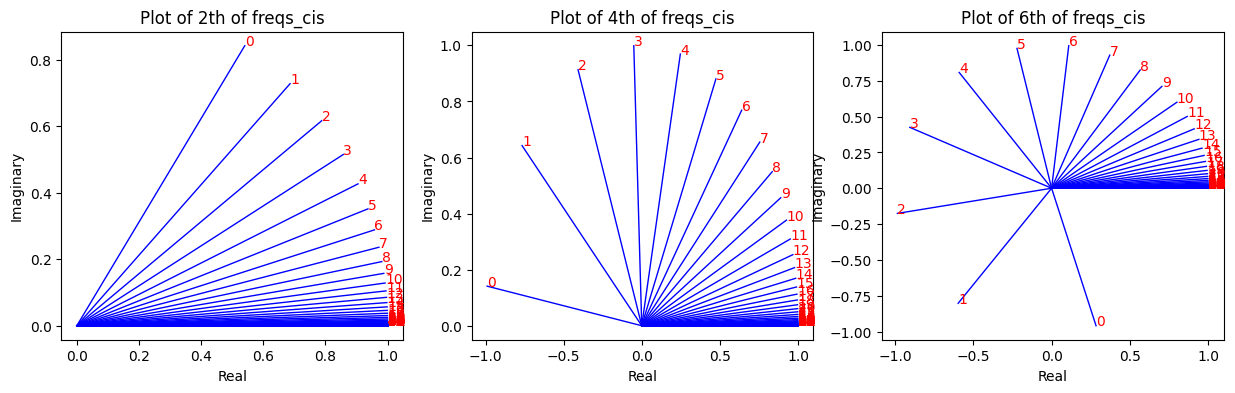

'\nNote: As shown in the figures, tokens in later positions have larger rotation angles, but within a single token, earlier vector dimensions have larger rotation angles.\n      You can explore further to see if there are any mathematical reasons behind this if you are interested. X_X\n'

In [24]:
# Obtain (cosmθ + sinmθi), that is, convert mθ to the complex-number form
# Regard the rotation angle mθ as a polar-coordinate form with a modulus of 1, and then convert it to a complex-number representation
# The two inputs of 'polar' represent the modulus (set to 1, meaning only the angle is changed without affecting the length) and the angle (i.e., mθ) respectively
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)  # [17x64] -> [17x64]
print(freqs_cis.shape)

# View freqs_cis at some positions, just for display
token_to_show = [1, 3, 5]  # View the 2nd, 4th, and 6th rows
fig, axs = plt.subplots(1, len(token_to_show), figsize=(5 * len(token_to_show), 4))  # Generate a figure window with 3 sub-plots in 1 row and 3 columns
for i, index in enumerate(token_to_show):
    value = freqs_cis[index]
    for j, element in enumerate(value):
        # Plot a blue line from the origin to the coordinate point, with the real part as the x-coordinate and the imaginary part as the y-coordinate.
        axs[i].plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {j}")
        # Draw red numerical annotations to represent the i-th pair of dimensions.
        axs[i].annotate(f"{j}", xy=(element.real, element.imag), color='red')
    axs[i].set_xlabel('Real')
    axs[i].set_ylabel('Imaginary')
    axs[i].set_title(f'Plot of {index + 1}th of freqs_cis')
plt.show()

"""
Note: As shown in the figures, tokens in later positions have larger rotation angles, but within a single token, earlier vector dimensions have larger rotation angles.
      You can explore further to see if there are any mathematical reasons behind this if you are interested. X_X
"""

<span style="font-size: 1.2em; font-weight: normal;">
Now we have provided a complex number (an angle-changing vector) for each dimension pair of the query vector corresponding to each token.
</span>
<br><br>
Now we can convert our query (the one divided into pairs) into complex numbers and then rotate these queries through dot-product calculation. :)

In [25]:
# Obtain (x + yi)
# That is, convert the dimension pairs into complex numbers. After the conversion, the shape of the dimensions will change from [17x64x2] to [17x64].
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)  # [17x64x2] -> [17x64]
q_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [26]:
# Calculate (x + yi) * (cosmθ + sinmθi)
# That is, perform the rotation operation to obtain the final result.
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis  # [17x64] * [17x64] = [17x64]
q_per_token_as_complex_numbers_rotated.shape

torch.Size([17, 64])

<span style="font-size: 1.2em; font-weight: normal;">
Obtain the rotated vectors (restore the shape).
</span>
<br><br>
We can represent the complex numbers as real numbers again to obtain the query results in the form of dimension pairs.

In [27]:
# Convert the complex-number results back to the real-number dimension-pair form.
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)  # [17x64] -> [17x64x2]
q_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

Merge the rotated dimensions. In this way, we obtain a new query vector (the rotated query vector) with a shape of [17x128], where 17 represents the number of tokens and 128 represents the dimension of the query vector.

In [28]:
# Restore the dimension-pair results to the original form of the query vectors, and obtain the final query vector.
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)  # [17x64x2] -> [17x128]
q_per_token_rotated.shape

torch.Size([17, 128])

#### Add positional information to the key vectors (same as the query)

In [29]:
# Split the key vectors into pairs along the dimension direction to form dimension pairs (modify the shape).
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)  # [17x128] -> [17x64x2]
k_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [30]:
# Obtain (x + yi)
# That is, convert the dimension pairs into complex numbers. After the conversion, the shape of the dimensions will change from [17x64x2] to [17x64].
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)  # [17x64x2] -> [17x64]
k_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [31]:
# Calculate (x + yi) * (cosmθ + sinmθi)
# That is, perform the rotation operation to obtain the final result.
# And convert the result back to the real-number form.
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)  # [17x64] * [17x64] = [17x64] -> [17x64x2]
k_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

In [32]:
# Restore the dimension-pair results to the original form of the key vectors, and obtain the final key vector.
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)  # [17x64x2] -> [17x128]
k_per_token_rotated.shape

torch.Size([17, 128])

<span style="font-size: 1.2em; font-weight: normal;">
At this stage, we have the rotated query vectors and key vectors corresponding to each token.
</span>

<div>
    <img src="images/keys0.png" width="600px"/>
</div>

The shape of each query and key vector remains [17x128].

### Everything's ready. Let's start calculating the attention weights between tokens.

This will involve a three-step process:
1. Calculate the attention scores: score = Q x K
2. Mask the future tokens: score = mask(score)
3. Calculate the attention weights: res = softmax(score)

Let's get started! :)

#### Multiply the query and key vectors to obtain the attention scores.

In this way, we will get the score values between each token and all other tokens.
<br>
These scores represent how strongly each token's query relates to every other token's key.
<br>
This is the self-attention!
<br>
The shape of this attention score matrix (qk_per_token) is [17x17], where 17 is the number of tokens in the input prompt.

<div>
    <img src="images/qkmatmul.png" width="600px"/>
</div>

In [33]:
# Calculate the attention score
# At the same time, perform normalization to prevent the subsequent softmax calculation results from being overly skewed towards 0 or 1,
# (the dot-product values may be too large when the dimensions are large),
# which could lead to vanishing gradients or exploding gradients, so as to maintain numerical stability.
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5  # [17x128] x [128x17] = [17x17]
qk_per_token.shape

torch.Size([17, 17])

#### Now we must mask the future query-key scores.

During the training process of Llama 3, the QK scores of future tokens will be masked.
<br>
Why? Because during training, we only learn how to use past tokens to predict the current token. If we don't mask future tokens, it will lead to the leakage of prediction information.
<br>
Therefore, during the inference process, we also need to set the future tokens to 0 (to ensure the logical consistency between the training and inference processes).
<br>

Of course, if you're as curious as I am about what would happen without masking, you can check the results of the additional experiment I conducted in the last section after you've finished learning. (^_<) 

<div>
    <img src="images/mask.png" width="600px"/>
</div>

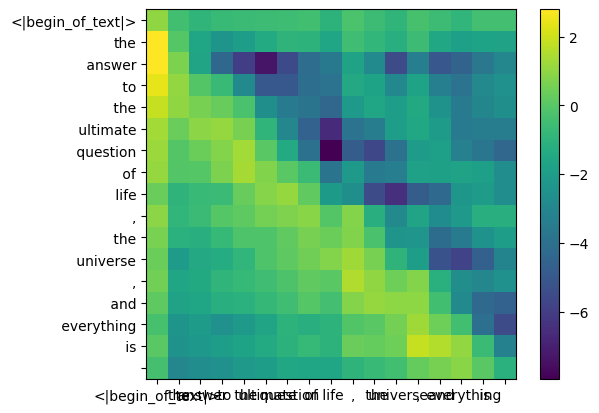

In [34]:
# First, take a look at the score matrix before masking
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()  # Create a figure window

    # `imshow` is commonly used to display data in the form of a two-dimensional array or matrix,
    # it maps the matrix elements to grayscale or color values, so it can be used to draw heatmaps.
    # Convert the tensor back to full precision, then detach it from the computational graph to avoid potential gradient calculation and storage issues.
    # Specify to use the 'viridis' color mapping scheme to display the image (blue -> green -> yellow).
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')

    # Set the number and labels of the x and y axis ticks to ensure correct one-to-one correspondence.
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)

    # Add a color bar on the side.
    # Specify `im` to identify the correct color mapping and value range.
    # Specify the sub-plot it belongs to as `ax` (if there are multiple sub-plots, it would be `ax = ax[i]`).
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token)

In [35]:
# Generate the masking matrix
# Set the positions of the elements to be masked to negative infinity, and set the positions that do not need to be masked to 0.
# Then, add it to the score matrix to achieve the masking effect (negative infinity will tend to 0 when calculating the softmax).

# `torch.full` is used to generate a tensor with a specified shape and filling value.
# Here, a [17x17] matrix filled with negative infinity is first generated.
# Specify that the device of this matrix is the same as that of the previous tokens to ensure that there are no errors in subsequent calculations,
# for example, if the previous tokens are on the GPU and the device is not specified here, the `mask` will be newly created on the CPU, and an error will occur when adding the two.
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)  # [17x17]

# `torch.triu` is used to return the upper-triangular part of the matrix, and set the rest to 0 (use `torch.tril` to get the lower-triangular part).
# `diagonal` is the offset of the diagonal. When it's 1, it means taking the upper-triangular part starting from 1 position above the main diagonal to avoid masking the token itself.
mask = torch.triu(mask, diagonal=1)  # [17x17]

mask, mask.shape

(tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf,

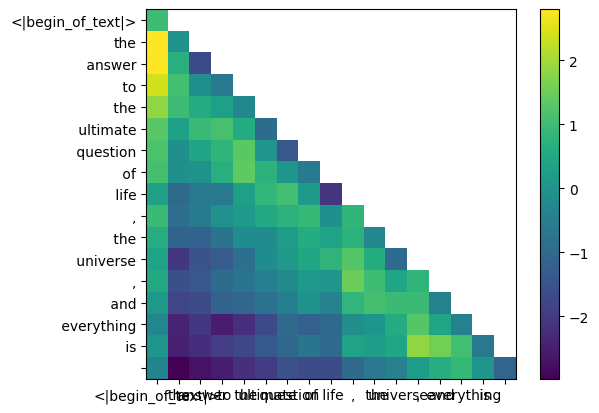

In [36]:
# Mask the scores of future tokens
qk_per_token_after_masking = qk_per_token + mask  # [17x17] + [17x17] = [17x17]
display_qk_heatmap(qk_per_token_after_masking)  # Display the attention scores after masking

#### Calculate the final attention weights, that is, softmax(score).
<div>
    <img src="images/softmax.png" width="600px"/>
</div>

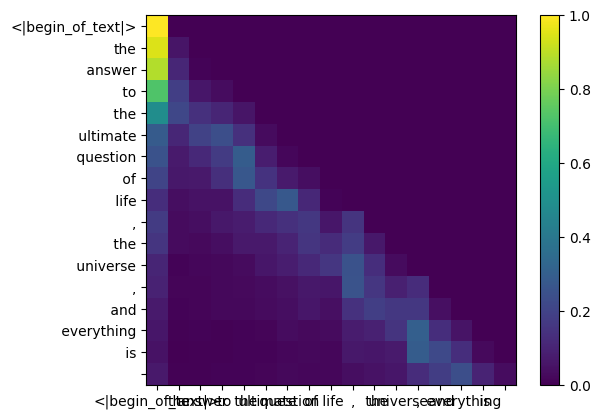

In [37]:
# Calculate the attention weights
# That is, calculate the softmax values of the scores.
# `dim = 1` indicates that the softmax calculation is performed row-by-row, and the result is converted to half-precision to be consistent with the subsequent value vectors.
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)  # [17x17] -> [17x17]
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

### Finally! Calculate the final result of the single-head attention mechanism!
<div>
    <img src="images/attention.png" width="600px"/>
</div>

Principle: The previous attention weights (ranging from 0 to 1) are used to determine what proportion of each value vector should be used for each token (i.e., to weight the value vectors).

Example: If the input consists of 3 tokens, the attention result of the first token might be: res = 0.6 * value_1 + 0.3 * value_2 + 0.1 * value_3

The shape of the attention result after the multiplication of the weight matrix and the value matrix is [17x128].

In [38]:
# Calculate the final result of the single-head attention
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)  # [17x17] x [17x128] = [17x128]
qkv_attention.shape

torch.Size([17, 128])

## Calculate the multi-head attention mechanism (a simple loop to repeat the above process)
<div>
    <img src="images/heads.png" width="600px"/>
</div>

We now have the attention values for the first head of the first layer.
<br>

Now we need to run a loop to perform exactly the same mathematical process as in the previous cell, but for each head in the first layer.
<br><br>

<span style="font-size: 1.2em; font-weight: bold;">
It's worth noting that in the <a href="https://github.com/meta-llama/llama3/blob/main/llama/model.py#L90">official Llama3 code implementation</a>, the multi-head attention calculation adopts the method of one-time matrix multiplication instead of time consuming for-loop calculations. The general process is as follows:
</span>

1. Based on matrix parallelism, calculate the QKV vectors: [17x4096] x [4096x4096] or [4096x1024] = [17x4096] or [17x1024], and then reshape them to [32x17x128] or [8x17x128].
2. After obtaining the QKV vectors, duplicate the internal parts of the K and V vectors to make their shapes consistent with the Q vector. At this time, the shapes of all of them are [32x17x128].
3. When calculating the scores, use the transpose method to exchange the positions of the last two dimensions of the tensors to complete the matrix multiplication. For example, `torch.matmul(q, k.transpose(1,2)) / head_dim ** 0.5`. At this time, it is [32x17x128] x [32x128x17] = [32x17x17].
4. The same principle applies to other matrix calculations.
<br>

Note: The matrix shape changes in each step of the above process are simplified versions, only for illustration to facilitate understanding, which are different from the change process in the official Llama3 implementation (the official implementation involves a large number of shape change processes). 

### Calculate the result for each head

In [39]:
# Calculate the multi-head attention results
# That is, a loop of the previous single-head attention calculation process
qkv_attention_store = []

for head in range(n_heads):
    # Extract the QKV weight matrices corresponding to the current head
    q_layer0_head = q_layer0[head]  # [32x128x4096] -> [128x4096]
    k_layer0_head = k_layer0[head//4]  # Every 4 heads share one key weight, [8x128x4096] -> [128x4096]
    v_layer0_head = v_layer0[head//4]  # Every 4 heads share one value weight, [8x128x4096] -> [128x4096]
    
    # Calculate XW to obtain the QKV vectors
    # [17x4096] x [4096x128] = [17x128]
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)
    
    # Add position information to the query vector (RoPE)
    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)  # Divide vector into pairs along the dimensions direction to form dimension pairs. [17x128] -> [17x64x2]
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)  # Convert to complex number representation, (x,y) -> (x+yi). [17x64x2] -> [17x64]
    q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis[:len(tokens)]  # Calculate (x+yi)*(cosmθ+sinmθi) to complete the rotation operation. [17x64] * [17x64] = [17x64]
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)  # Convert the result back to real number representation, (x+yi) -> (x,y). [17x64] -> [17x64x2]
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)  # Convert the result back to the original vector shape to obtain the final query vector. [17x64x2] -> [17x128]

    # Add position information to the key vector (RoPE)
    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)  # Divide vector into pairs along the dimensions direction to form dimension pairs. [17x128] -> [17x64x2]
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)  # Convert to complex number representation, (x,y) -> (x+yi). [17x64x2] -> [17x64]
    k_per_token_as_complex_numbers_rotated = k_per_token_as_complex_numbers * freqs_cis[:len(tokens)]  # Calculate (x+yi)*(cosmθ+sinmθi) to complete the rotation operation. [17x64] * [17x64] = [17x64]
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers_rotated)  # Convert the result back to real number representation, (x+yi) -> (x,y). [17x64] -> [17x64x2]
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)  # Convert the result back to the original vector shape to obtain the final key vector. [17x64x2] -> [17x128]

    # Calculate the attention scores and normalize the scores simultaneously (i.e., Q×K/sqrt(dim))
    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5  # [17x128] x [128x17] = [17x17]
    
    # Mask the scores of future tokens
    mask = torch.full(qk_per_token.shape, float("-inf"), device=tokens.device)  # Create a matrix with the same shape as the attention scores, filled with negative infinity, and stored in the same device as other vectors to prevent errors in subsequent calculations. [17x17]
    mask = torch.triu(mask, diagonal=1)  # Keep the negative infinity in the upper-triangular part and set others to 0 (i.e., the upper-triangular area represents future tokens that need to be masked). The diagonal offset is 1 to avoid masking the token itself. [17x17]
    qk_per_token_after_masking = qk_per_token + mask  # Add the attention scores with the masking matrix, making the upper-triangular part of the score matrix become negative infinity, which will tend to 0 after the subsequent softmax operation. [17x17]
    
    # Calculate the attention weights (i.e., softmax(score))
    # Meanwhile, convert it back to half-precision (because it will be multiplied with the value vector v_per_token later, so the data types need to be the same).
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)  # Calculate the softmax row-by-row. [17x17]
    
    # Calculate the final result of the attention mechanism (i.e., softmax(score) × V)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)  # [17x17] × [17x128] = [17x128]
    
    # Record the result of this head
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

### Merge the results of each head into a large matrix

<div>
    <img src="images/stacked.png" width="600px"/>
</div>
Now we have the results of the attention mechanism for all 32 heads in the first layer. Next, we'll merge all the attention values into a large matrix with a shape of [17x4096].
<br>
We're almost done with the calculation of the attention layer :)

In [40]:
# Merge the multi-head attention matrices
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)  # Concatenate along the second dimension, 32x[17x128] -> [17x4096]
stacked_qkv_attention.shape

torch.Size([17, 4096])

### Head-to-head information interaction (linear mapping), the final step of the self-attention layer!
<div>
    <img src="images/weightmatrix.png" width="600px"/>
</div>
The last step of the attention calculation for layer0 is to perform the final linear mapping, that is, multiply the combined attention matrix by the output weight matrix.

In [41]:
# Load the output weight matrix of layers.0
w_layer0 = model["layers.0.attention.wo.weight"]  # [4096x4096]
w_layer0.shape

torch.Size([4096, 4096])

This is just a simple linear layer, so we only need matrix multiplication.

In [42]:
# Perform the linear mapping of the attention matrix
# This is the final output of the attention layer
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)  # [17x4096] x [4096x4096] = [17x4096]
embedding_delta.shape

torch.Size([17, 4096])

## Perform the residual operation (add)

<div>
    <img src="images/afterattention.png" width="600px"/>
</div>
Now we have the value of the input vector after the attention mechanism is applied. At this time, we need to add the original input vector to it (i.e., the residual operation, to ensure that information is not easily lost and alleviate the problem of gradient vanishing).

In [43]:
# Add the output of the attention layer to the original input to complete the residual operation
embedding_after_edit = token_embeddings_unnormalized + embedding_delta  # [17x4096] + [17x4096] = [17x4096]
embedding_after_edit.shape

torch.Size([17, 4096])

## Perform the second normalization operation
<div>
    <img src="images/norm_after.png" width="600px"/>
</div>

In [44]:
# Normalize the result of the residual operation
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])  # [17x4096] & [4096] -> [17x4096]
embedding_after_edit_normalized.shape

torch.Size([17, 4096])

## Perform the calculation of the FFN (Feed-Forward Neural Network) layer
<div>
    <img src="images/swiglu.png" width="600px"/>
</div>
<br>
In Llama3, they used the SwiGLU feed-forward network. This network architecture can effectively increase nonlinear characteristics when the model needs.
<br>
Nowadays, this kind of feed-forward network architecture is very common in large language models.
<br><br>

<span style="font-size: 1.2em; font-weight: bold;">Why Introduce Nonlinear Layers:</span>
<br>

- The Nonlinearity is at the core of why neural network models can be considered "universal function approximators". In traditional neural network models, we use nonlinear activation functions (such as sigmoid, ReLU, etc.) to increase the model's expressive power, enabling it to fit the complex patterns hidden in the training data.
- However, in the Transformer, the attention mechanism is essentially a linear weighted sum of the value vectors (even though the weights are obtained through nonlinear calculation of the softmax function, it's still just a linear weighting for the values). Therefore, although it can capture global dependencies, its output is still only a linear combination of the input. At this time, the Transformer model is actually lacks nonlinear capabilities.
- So, it is necessary to add an FFN network after the self-attention layer to introduce nonlinear transformation capabilities to the model, thus improving the model's ability to model complex semantic relationships.
<br>

<span style="font-size: 1.2em; font-weight: bold;">Generally, introducing nonlinear layers can play the following roles:</span>

1. Add nonlinear capabilities to the model to facilitate the model's learning and training.
2. Enhance the model's information abstraction ability, enabling the model to represent data features and patterns at different levels during the layer-by-layer learning process. For example, the lower-layer networks can identify basic language structures (such as part-of-speech), while the higher-layer networks can understand more complex semantic information (such as sentiment, intention).
3. In addition, a current view holds that the attention layer is mainly used for input context interaction, while the FFN layer is where the LLMs mainly stores and remembers general knowledge during training (given to its nonlinear representation ability), so that it can find answers to input questions from general knowledge.
<br><br>

<span style="font-size: 1.5em; font-weight: bold;">SwiGLU Network Structure:</span>

1. Perform a linear transformation on the input: $X^\prime = XW_3$
2. Gating unit: $GATE = Activation\_Function(XW_1)$, which is used to selectively pass information. That is, assuming that the information in $X^\prime$ has different importance, so the information should be weighted and passed based on the score of the gating unit, thus improving the expressive ability of the model.
3. The activation function used is a Swish activation function (hence the network is called SwiGLU, which is a combination of the Swish activation function and the Gated Linear Unit (GLU)). The formula is: $Swish = X \cdot \sigma(\beta X)$, where $\sigma$ is the sigmoid activation function. In SwiGLU, $\beta$ is set to 1 (in the original formula, it is a learnable parameter).
4. Therefore, the specific calculation of the gating unit is: $GATE = XW_1 \cdot \sigma(XW_1)$. In PyTorch, this activation function is called silu, that is $GATE = silu(XW_1)$.
5. Application of the gating mechanism: $X^\prime = X^\prime \cdot GATE$
6. Perform a linear transformation again: $Y = X^\prime W_2$
<br><br>

<span style="font-size: 1.5em; font-weight: bold;">Calculation of the Dimension Size of the Hidden Layer in the Feed-Forward Layer (Based on the Official Implementation Process of Llama3):</span>

1. Input dimension is dim = 4096
2. hidden_dim = 4 * dim = 16384  # First, magnify it by four times. When initializing the feed-forward layer in the Transformer block, the input hidden_dim is multiplied by four.
3. hidden_dim = int(2 * hidden_dim / 3) = 10922 # Then, magnify it by 2/3 times. Such scaling is first performed within the feed-forward layer.
4. hidden_dim = int(ffn_dim_multiplier * hidden_dim) = int(1.3 * 10922) = 14198  # Then, magnify it by ffn_dim_multiplier times. The ffn_dim_multiplier is defined as 1.3 in the model configuration file.
5. hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of) = 1024 * ((14198 + 1024 - 1) // 1024) = 14336  # Adjust it to an integer multiple of multiple_of. The multiple_of is defined as 1024 in the model configuration file to ensure that the dimensions of all hidden layers in the model are multiples of 1024, so as to improve the computational efficiency.
6. Finally, we get the dimension size of the hidden layer is 14336.

In [45]:
# Calculate the feed-forward network layer
# The dimension size of the hidden layer is 14336
w1 = model["layers.0.feed_forward.w1.weight"]  # [14336x4096]
w3 = model["layers.0.feed_forward.w3.weight"]  # [14336x4096]
w2 = model["layers.0.feed_forward.w2.weight"]  # [4096x14336]
print(w1.shape, w3.shape, w2.shape)

# output = (silu(XW1) * XW3)W2
# [17x4096] x [4096x14336] x [14336x4096] = [17x4096]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([14336, 4096]) torch.Size([14336, 4096]) torch.Size([4096, 14336])


torch.Size([17, 4096])

## Perform the residual operation again (Finally, we get the final output of the Transformer block!)

In [46]:
# Add the output of the feed-forward layer to the original input to complete the residual operation
# This is the final result of a Transformer block
layer_0_embedding = embedding_after_edit+output_after_feedforward  # [17x4096] + [17x4096] = [17x4096]
layer_0_embedding.shape

torch.Size([17, 4096])

<span style="font-size: 1.5em; font-weight: normal;">
Finally, we have the new embeddings of each token after passing through the first layer.
</span>
<br><br>
There are only 31 layers left to complete (just one for loop away).
<br>
You can imagine that this processed embedding contains all the information of the tokens proposed in the first layer.
<br>
Now, each layer will encode more complex queries in the asked question. Until the end, we will get an embedding that knows all the information about the next token we need.

# Everything is here. Let's complete the calculation of all 32 Transformer blocks. Happy reading :)
<div>
    <img src="images/god.png" width="600px"/>
</div>

Yes, that's it. All the work we've done before will be presented here at once to complete the calculation of each layer.
<br>

In [47]:
# Now, let's start to complete the calculation of all 32 Transformer blocks!

# Use the embeddings of the input tokens as the initial input.
final_embedding = token_embeddings_unnormalized  # [17x4096]

# Perform layer-by-layer calculation for the 32-layer Transformer blocks
for layer in range(n_layers):
    #########################################################################################################################
    ################### Round 1: Normalization - Feature Transformation - Residual Operation ###############################
    
    ########################### The first normalization ###################################################
    
    # The first normalization
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])  # [17x4096] & [4096] -> [17x4096]
    
    ################ The first feature transformation - Multi-Head Self-Attention ########################
    
    # Obtain the qkv weight matrix of the attention mechanism for the current layer
    q_layer = model[f"layers.{layer}.attention.wq.weight"]  # [4096x4096]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)  # [32x128x4096]
    k_layer = model[f"layers.{layer}.attention.wk.weight"]  # [1024x4096]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)  # [8x128x4096]
    v_layer = model[f"layers.{layer}.attention.wv.weight"]  # [1024x4096]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)  # [8x128x4096]
    
    # Used to store the calculation results of the attention mechanism for each head
    qkv_attention_store = []
    
    # Calculate the attention mechanism results for each head
    for head in range(n_heads):
        # Extract the QKV weight matrices corresponding to the current head
        q_layer_head = q_layer[head]  # [32x128x4096] -> [128x4096]
        k_layer_head = k_layer[head//4]  # Every 4 heads share one key weight, [8x128x4096] -> [128x4096]
        v_layer_head = v_layer[head//4]  # Every 4 heads share one value weight, [8x128x4096] -> [128x4096]
        
        # Calculate XW to obtain the QKV vectors
        # [17x4096] x [4096x128] = [17x128]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        
        # Add position information to the query vector (RoPE)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)  # Divide vector into pairs along the dimensions direction to form dimension pairs. [17x128] -> [17x64x2]
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)  # Convert to complex number representation, (x,y) -> (x+yi). [17x64x2] -> [17x64]
        q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis  # Calculate (x+yi)*(cosmθ+sinmθi) to complete the rotation operation. [17x64] * [17x64] = [17x64]
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)  # Convert the result back to real number representation, (x+yi) -> (x,y). [17x64] -> [17x64x2]
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)  # Convert the result back to the original vector shape to obtain the final query vector. [17x64x2] -> [17x128]
        
        # Add position information to the key vector (RoPE)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)  # Divide vector into pairs along the dimensions direction to form dimension pairs. [17x128] -> [17x64x2]
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)  # Convert to complex number representation, (x,y) -> (x+yi). [17x64x2] -> [17x64]
        k_per_token_as_complex_numbers_rotated = k_per_token_as_complex_numbers * freqs_cis  # Calculate (x+yi)*(cosmθ+sinmθi) to complete the rotation operation. [17x64] * [17x64] = [17x64]
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers_rotated)  # Convert the result back to real number representation, (x+yi) -> (x,y). [17x64] -> [17x64x2]
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)  # Convert the result back to the original vector shape to obtain the final key vector. [17x64x2] -> [17x128]
        
        # Calculate the attention scores and normalize the scores simultaneously (i.e., Q×K/sqrt(dim))
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5  # [17x128] x [128x17] = [17x17]
        
        # Mask the scores of future tokens
        mask = torch.full(qk_per_token.shape, float("-inf"), device=qk_per_token.device)  # Create a matrix with the same shape as the attention scores, filled with negative infinity, and stored in the same device as other vectors to prevent errors in subsequent calculations. [17x17]
        mask = torch.triu(mask, diagonal=1)  # Keep the negative infinity in the upper-triangular part and set others to 0 (i.e., the upper-triangular area represents future tokens that need to be masked). The diagonal offset is 1 to avoid masking the token itself. [17x17]
        qk_per_token_after_masking = qk_per_token + mask  # Add the attention scores with the masking matrix, making the upper-triangular part of the score matrix become negative infinity, which will tend to 0 after the subsequent softmax operation. [17x17]
        
        # Calculate the attention weights (i.e., softmax(score))
        # Meanwhile, convert it back to half-precision (because it will be multiplied with the value vector v_per_token later, so the data types need to be the same).
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)  # Calculate the softmax row-by-row. [17x17]
        
        # Calculate the final result of the attention mechanism (i.e., softmax(score) × V)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)  # [17x17] x [17x128] = [17x128]
        
        # Record the result of this head
        qkv_attention_store.append(qkv_attention)
    
    # Merge the multi-head attention results
    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)  # Merge the second dimension, that is, 32x[17x128] -> [17x4096]
    
    # Perform a linear mapping on the results to generate the final multi-head self-attention mechanism results
    o_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, o_layer.T)  # [17x4096] x [4096x4096] = [17x4096]

    ########################### The first residual operation ##############################################
    
    # The first Residual Operation
    # Add the output of the attention layer to the original input to complete the residual operation
    embedding_after_edit = final_embedding + embedding_delta  # [17x4096] + [17x4096] = [17x4096]
    
    
    #########################################################################################################################
    #################### Round 2: Normalization - Feature Transformation - Residual Operation ##############################
    
    ########################### The second normalization ##################################################
    
    # The second normalization
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])  # [17x4096] & [4096] -> [17x4096]
    
    ################## The second feature transformation - Feed-Forward Network ##########################
    
    # Load the parameter matrix of the feed-forward network (SwiGLU)
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]  # [14336x4096]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]  # [14336x4096]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]  # [4096x14336]
    
    # Calculate the results of the feed-forward network (output = (silu(XW1) * XW3)W2)
    # [17x4096] x [4096x14336] x [14336x4096] = [17x4096]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    
    ########################### The second residual operation ##############################################
    
    # The second residual operation, obtain the final output result of the current Transformer block
    # Add the output of the feed-forward layer to the original input to complete the residual operation
    final_embedding = embedding_after_edit+output_after_feedforward  # [17x4096] + [17x4096] = [17x4096]

# Let's complete the last step and predict the next token

Now we have obtained the final embeddings, which contains all the information we needed to predict the next token.
<br>
The shape of this embedding is the same as that of the input token embedding, both being [17x4096], where 17 is the number of tokens and 4096 is the dimension of the embedding.

<div>
    <img src="images/last_norm.png" width="600px"/>
</div>

## First, perform one last normalization on the output of the last Transformer layer

In [48]:
# Perform the last normalization in the entire model
final_embedding = rms_norm(final_embedding, model["norm.weight"])  # [17x4096] & [4096] -> [17x4096]
final_embedding.shape

torch.Size([17, 4096])

## Then, make the prediction based on the embedding corresponding to the last token (perform a linear mapping to the vocabulary dimension)

<div>
    <img src="images/finallayer.png" width="600px"/>
</div>

<br>
We will use the output decoder (a linear mapping layer) to convert the embedding vector of the last token into a prediction result for the next token (the dimension is the size of the vocabulary. If we apply a softmax function to the result, the value of each dimension represents the probability that the next token belongs to that word).
<br><br>

Why do we only use the output vector of the last token to predict the next token?
<br>
Because during training, the model's objective is to predict the next token based on the current token and all previous tokens. Therefore, the output vector corresponding to each token is used to predict the next token relative to itself, rather than the next token for the entire input.
<br><br>

We hope the answer is 42 in our example :)
<br>
Note: 42 is the answer to "the answer to the ultimate question of life, the universe, and everything is " according to the book *The Hitchhiker's Guide to the Galaxy*. Most modern large language models will answer 42, which will verify the correctness of our entire code! Good luck to us :)

In [49]:
# Perform the last linear mapping to map the embeddings to the size of the vocabulary dimension as a prediction for the next token
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)  # [17x4096] -> [4096] -> [4096] x [4096x128256] = [128256]
logits.shape

torch.Size([128256])

## Here's the prediction result!

In [50]:
# Extract the id corresponding to the dimension with the highest probability,
# is gonna be the predicted next token's id
next_token = torch.argmax(logits, dim=-1)  # Get the index corresponding to the maximum value, which is the predicted next token id. [128256] -> [1]
next_token

tensor(2983)

In [51]:
# Based on the predicted id, restore it to the specific predicted value
tokenizer.decode([next_token.item()])

'42'

<div>
    <img src="images/42.png" width="600px"/>
</div>

# Let's dive deeper and see how different embeddings or token masking strategies might affect the prediction results :)

Now we've got the final prediction results. If you're still interested, let's explore some of the issues that might have been mentioned before~
<br>

We'll briefly explore three scenarios:
1. Apart from the top-1 result, what else is predicted in the current prediction, that is, the top-k results?
2. What can be predicted if we use the output embedding of other tokens for prediction?
3. If the future tokens were not masked during the attention calculation before, how would the prediction results differ?

In [52]:
# Let's first take a look at the top-k prediction results
logits_sort, logits_idx = torch.sort(logits, dim=-1, descending=True)  # Put the token with the highest probability prediction at the front, [128256]
[tokenizer.decode([i]) for i in logits_idx[:10]]  # View the top 10 high-probability results

['42', '6', '43', '41', '4', '1', '45', '3', '2', '46']

In [53]:
# Next, let's to see what can we get by using the embeddings of other tokens for prediction
logits_all_token = torch.matmul(final_embedding, model["output.weight"].T)  # Map the embeddings to the same size as the vocabulary, [17x4096] x [4096x128256] = [17x128256]
logits_all_token_sort, logits_all_token_idx = torch.sort(logits_all_token, dim=-1, descending=True)  # Put the token with the highest probability prediction at the front, [17x128256]

print('Input tokens:', prompt_split_as_tokens)  # Display the input tokens, [17]

# Display the results of the next-token prediction based on the output embedding of each token
for i in range(len(final_embedding)):
    print(f'Predict results based on {i+1}th token:', [tokenizer.decode([j]) for j in logits_all_token_idx[i][:10]])  # Output the top 10 high-probability results
    
_="""
It can be seen that when making predictions based on each token, the prediction result is the possible result of the next token after the "current token",
rather than the prediction result of the entire complete input.
Therefore, in actual prediction, only the embedding of the last token will be used for prediction.
"""

Input tokens: ['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']
Predict results based on 1th token: ['Question', 'def', '#', 'The', 'import', 'Tags', 'A', 'package', 'Home', 'I']
Predict results based on 2th token: [' ', ' best', ' first', ' most', ' new', ' world', ' last', ' same', ' way', ' number']
Predict results based on 3th token: [' to', ' is', ' was', ' of', ' lies', ',', ' for', ' you', ' key', ' will']
Predict results based on 4th token: [' the', ' this', ' your', ' all', ' that', ' a', ' my', ' life', ' "', ' everything']
Predict results based on 5th token: [' question', ' problem', ' above', ' ultimate', ' first', ' r', ' following', ' questions', ' most', ' previous']
Predict results based on 6th token: [' question', ' questions', ' mystery', '\xa0', ' quest', '\n', ' life', ' philosophical', ' qu', ' problem']
Predict results based on 7th token: [' of', '\n', 

In [54]:
# Finally, let's take a look at what the prediction results will be if we don't mask future tokens when calculating attention
# At this time, the prediction results based on each token will be as follows
# It can be seen that due to the visibility of future tokens, the embeddings of each token will more accurately predict "the next token for it" (it's a bit like "cheating") 

_="""
Input tokens: ['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']
Predict results based on 1th token: ['://', '.Forms', '_REF', ' Angeles', '.swing', '�', 'php', 'во', 'ysics', '�']
Predict results based on 2th token: [' answer', ' Hitch', ' universe', ' question', ' ultimate', ' meaning', ' hitch', ' Universe', ' Answer', ' reason']
Predict results based on 3th token: [' to', ' is', ',', ':', ' was', '\n', ' ', ' (', '\n\n', ' of']
Predict results based on 4th token: [' the', ' life', ' this', ' which', ' everything', ' that', ' how', ' why', ' ', ' all']
Predict results based on 5th token: [' ultimate', ' question', ' great', ' meaning', ' universe', ' Ultimate', ' everything', ' life', ' holy', ' greatest']
Predict results based on 6th token: [' question', ' answer', ' is', ' was', '\n', ' questions', ' mystery', '\n\n', ' what', ' Question']
Predict results based on 7th token: [' of', ' is', '\n', ',', ' about', ':', ' to', ' in', ' (', '<|end_of_text|>']
Predict results based on 8th token: [' life', ' existence', ' everything', ' Life', ' the', ' death', ' time', ' all', ' why', ' which']
Predict results based on 9th token: [',', ' is', ' the', '\n', ':', ' (', '...', ' and', ' ,', ' -']
Predict results based on 10th token: [' the', ' and', ' is', ' death', ' The', ' which', ' or', '\xa0', ' existence', ' don']
Predict results based on 11th token: [' universe', ' answer', ' cosmos', ' world', ' existence', ' Universe', ' everything', ' un', ' meaning', ' question']
Predict results based on 12th token: [',', ' and', ' is', ' &', '\n', ' ,', '.', '...', ' (', ' ']
Predict results based on 13th token: [' and', ' &', ' don', ' the', ' is', ' a', ' or', ' Douglas', '\xa0', '<|end_of_text|>']
Predict results based on 14th token: [' everything', ' dough', ' don', ' ever', ' deep', ' Douglas', ' the', ' every', ' all', ' death']
Predict results based on 15th token: ['\n', ' is', ',', '.', ' ', ' (', ':', '<|end_of_text|>', '\n\n', '.\n']
Predict results based on 16th token: [' ', '\n', ' forty', '...', ' "', '42', ' the', ':', '\xa0', ' to']
Predict results based on 17th token: ['42', '6', '4', '41', '1', '2', '3', '7', '5', '43']
"""

# Need to predict multiple tokens? Just using KV-Cache! (It really took me a lot of effort to sort this out. Orz)


<span style="font-size: 1.5em; font-weight: bold;">How to Continuously Predict Multiple Tokens</span>

Now, we've completed the prediction of the next word for the input text. But what if our expected output requires multiple tokens?
<br>
For example, in practical llm applications, models usually don't output just one word. Instead, they often output a passage of text, or even a very long text. How is this ability achieved?
<br>
Actually, it's quite simple. We just need to repeatedly call the llm's prediction process to gradually generate a complete sentence or paragraph.
<br>
This process is like "snowballing". Each time we predict a word, we add this word to the current input sequence, and then call the model again for a new round of prediction. The prediction stops when we encounter a stop symbol (a special token "<|end_of_text|>" in llama3) or reach the maximum length limit (a hyperparameter max_seq_len).
<br><br>
Does this sound inefficient? Yes!
<br>
That's why there are well-known caching mechanisms like KV-Cache. By caching the KV vectors of historical tokens, we can reduce the input and computational load, thus improving the inference efficiency.
<br>
Thanks to the caching mechanism, when we use a large model for inference, you may notice that waiting for the first token to be output is often the most time-consuming. But once the first token is output, the output speed of subsequent tokens will increase significantly.
<br><br>

<span style="font-size: 1.5em; font-weight: bold;">Advantages and Disadvantages of KV-Cache</span>

**Advantage**: When continuously predicting, we only need to input the new token each time instead of the entire text sequence. This greatly improves the calculation speed during inference.
<br>
**Disadvantage**: Due to the caching mechanism, it will consume more memory resources during inference.
<br><br>

<span style="font-size: 1.5em; font-weight: bold;">Principle Derivation of KV-Cache</span>

KV-Cache comes from the observation and analysis of the above matrix calculation process. By analyzing the calculation process of each input token, we can find that in most calculation steps, the calculation of each token is actually relatively independent and rately involves interaction with other tokens. Only when calculating the attention mechanism will token-to-token interactions be involved, thus requiring the caching of historical KV vectors.
<br>

<span style="font-size: 1.2em; font-weight: bold;">Here is the specific derivation logic of KV-Cache:</span>
1. **Premise**: To predict the next token, we only need to get the output result of the last token (just as we did in the prediction chapter).
2. **Non-attention parts only needs to calculate the new tokens**: Except for the attention calculation, the calculations of all other parts are independent among tokens. So we only need to calculate the new tokens and don't need to input historical tokens (I'll expand the analysis below).
3. **Attention parts also only needs to calculate the new tokens**: In the attention layer, due to the masking mechanism, the output results of historical tokens won't be affected by future new tokens. So their inputs and outputs at each layer are fixed, that is, the QKV vectors of historical tokens will not change because of the addition of new tokens. Thus, we only need to calculate the attention of the new tokens.
4. **Calculate the new token's attention mechanism**: The attention layer is used to let the token obtain the context information of historical tokens. So, for each new token, we need to calculate the weighted sum using the value vectors of all tokens. Therefore, we need to store the values of historical tokens.
5. **Calculate the new token's attention weights**: As known from point 4, we also need to obtain the importance information, i.e., weights, between the new tokens and historical tokens first. So we need to calculate the product of the key vectors of the new tokens with the key vectors of all tokens. Therefore, we need to store the keys of historical tokens.
6. **Acquisition of KV-Cache**: As known from points 4 and 5, we need to store the KV vectors of historical tokens. Since the query vectors are not used, we don't need to store them. This is how the kv-cache came about.
7. **Efficiency of KV-Cache**: As known from point 3, the historical KV vectors won't change. So they can be incrementally updated during the continuous prediction process without modifying the historical content. In this way, each time we predict, we only need to input and calculate the result of the newly added tokens instead of taking the complete sequence as input, thus greatly improving the inference efficiency.
<br><br>

<span style="font-size: 1.2em; font-weight: bold;">Additional: Analysis of the Independence of Token Calculation in KV-Cache</span>

**All components except the attention layer (no interaction among them)**:
1. **Two times normalizations**: Each token vector is normalized in its own feature dimension without using other tokens.
2. **Two times residual connections (add)**: Each token vector adds its own output result to itself without using other tokens.
3. **Feed-forward network (FFN)**: Each token vector is multiplied by the same weight matrices W1, W2, W3 to get the result, and other tokens are not used during this process. Imagine that if the number of input tokens is 17, the calculation of FFN can be simplified as: [17x4096] x [4096x14336] x [14336x4096] = [17x4096]. This is actually equivalent to inputting one token at a time and then concatenating the 17 results into a matrix, that is: 17 times ([1x4096] x [4096x14336] x [14336x4096] = [1x4096]) = 17x[1x4096] => [17x4096]. Therefore, when each token is calculated in the feed-forward layer, there is actually no interaction with other tokens.

**Attention layer (only have one-way interaction between new tokens and historical tokens)**:
1. **Calculate QKV vectors**: Each token vector is multiplied by the same QKV weight matrices to get the result without using other tokens.
2. **Add positional information to QK vectors**: Each token vector performs an independent rotation operation based on its own position without using the specific content of other tokens.
3. **Calculate attention weights**: The attention weights represent the correlation between each token and every historical tokens preceding it, and are independent of future tokens. Therefore, the results of historical tokens are independent of new tokens. And new tokens need the key vector cache of historical tokens.
4. **Calculate the result of the attention mechanism**: The attention mechanism calculates the weighted sum of value vectors based on attention weights. So, similar to the conclusion in the previous point, the results of historical tokens are also independent of new tokens. And new tokens need the value vector cache of historical tokens.
<br><br>

<span style="font-size: 1.5em; font-weight: bold;">Attention Calculation Process Based on KV-Cache</span>

To clearly show the calculation process, we only derive the single-head scenario (the principle and process of extending it to the multi-head scenario are exactly the same as the previous multi-head attention implementation):
1. Assume that the historical input tokens are $S_1$ with a length of N. Based on KV-Cache, we will store the KV result matrix of each head. The shape of a single head is [Nxhead_dim] = [Nx128].
2. Assume that the newly added input tokens are $S_2$ with a length of M (it can be newly predicted tokens or the input of a new round of user dialogue or any other scenarios).
3. Calculate the QKV vectors of the new tokens: $Q,K,V = S_2W_{Q,K,V}$ => [Mx4096] x [4096x128] = [Mx128].
4. Add positional information to the QK vectors: The positions of new tokens should start from N + 1, not from 0. [Mx128] -> [Mx128].
5. Add the new KV values to the KV cache to get the updated KV matrix, that is, [Nx128] -> [(N + M)x128].
6. Calculate the attention weights of the new tokens: Attention_weight = softmax(QK/sqrt(d) + mask) => [Mx128] x [128x(N + M)] = [Mx(N + M)].
7. Calculate the final result of the attention mechanism for the new tokens: Attention_weight x V => [Mx(N + M)] x [(N + M)x128] = [Mx128].
8. Concatenate the results of each head and perform a linear mapping to get the final output of the attention layer, with a shape of 32x[Mx128] -> [Mx4096].
<br><br>

Since our previous learning process has been quite comprehensive, we won't implement the code for the optimization scheme here (if you're interested, you can refer to the official code of Llama 3, which is relatively easy to implement). Just like the parallel calculation of multi-head attention mentioned before, knowing that the calculation process can be optimized is enough~

# Thank you all. Thanks for your continuous learning. Love you all :)

Our learning has come to an end. I hope you have also enjoyed this reading process!

## From Me
If you've come across this work, thank you for your trust and for learning all the way to this point. I'm glad to be of help to you~
<br>

If you'd like to support my work
1. give it a star⭐~ :) 
2. buy me a coffee~ [https://ko-fi.com/therealoliver](https://ko-fi.com/therealoliver)

<br>

## From the author of predecessor project

If you want to support my work

1. follow me on twitter https://twitter.com/naklecha 
2. or, buy me a coffee [https://www.buymeacoffee.com/naklecha](https://www.buymeacoffee.com/naklecha)

Honestly, if you made it this far you already made my day :)

what motivates me?

My friends and I are on a mission - to make research more accessible!
We created a research lab called A10 - [AAAAAAAAAA.org](http://aaaaaaaaaa.org/)

A10 twitter - https://twitter.com/aaaaaaaaaaorg

our thesis:
<div>
    <img src="images/a10.png" width="600px"/>
</div>
<br><br>
Thanks again to the original author for the base code and illustrations, which also taught me a lot

# LICENSE

Copyright (c) 2025 Jinlong Zhang (https://github.com/therealoliver)

Copyright (c) 2024 Nishant Aklecha

MIT